# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes, 
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization. 

In [26]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

In [27]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [28]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [29]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


In [30]:
#Training:
def loading_data(batch_size):
    # The dataloader makes our dataset iterable 
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    return train_dataloader, val_dataloader
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        # First, we need to convert the input image to a vector by using 
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes 
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)
        
    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x
def train_multiple_epochs(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs):
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")
    return train_acc_all, val_acc_all
#create dataloader for test data
# The dataloader makes our dataset iterable 
def loading_test_data(batch_size_test):
    #batch_size_test = 256
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)
    return test_dataloader
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1


In [31]:
train_dataloader, val_dataloader = loading_data(128)
test_dataloader = loading_test_data(256)

In [32]:
%%time
linear_model = LinearClassifier()
#print(linear_model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)
train_acc_all, val_acc_all = train_multiple_epochs(linear_model, train_dataloader, val_dataloader, loss_fn, optimizer, 5)

Epoch 0: training loss: 0.5029035700162252, accuracy: 87.56458333333333
Epoch 0: val. loss: 0.49488582573038464, val. accuracy: 87.69166666666666
Epoch 1: training loss: 0.42193881118297577, accuracy: 89.03333333333333
Epoch 1: val. loss: 0.4123444525485343, val. accuracy: 88.9
Epoch 2: training loss: 0.3877951551675797, accuracy: 89.68958333333333
Epoch 2: val. loss: 0.37767356792663004, val. accuracy: 89.51666666666667
Epoch 3: training loss: 0.3677475307782491, accuracy: 90.1125
Epoch 3: val. loss: 0.3574871948741852, val. accuracy: 89.925
Epoch 4: training loss: 0.35412003513177237, accuracy: 90.39791666666666
Epoch 4: val. loss: 0.34390263386229253, val. accuracy: 90.26666666666667
CPU times: user 4min 47s, sys: 117 ms, total: 4min 47s
Wall time: 29.9 s


Test loss: 0.3327, test accuracy: 90.86%
Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


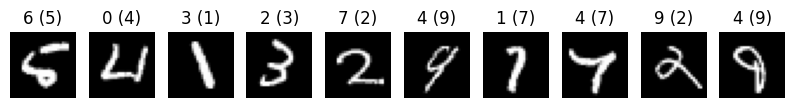

In [38]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))
show_failures(linear_model, test_dataloader)


In [34]:
%%time
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)
train_acc_all, val_acc_all = train_multiple_epochs(nonlinear_model, train_dataloader, val_dataloader, loss_fn, optimizer, 5)

Epoch 0: training loss: 0.8115735710461934, accuracy: 76.79375
Epoch 0: val. loss: 0.8023271947465045, val. accuracy: 76.69166666666666
Epoch 1: training loss: 0.39288973474502564, accuracy: 89.04166666666666
Epoch 1: val. loss: 0.381742943157541, val. accuracy: 89.11666666666666
Epoch 2: training loss: 0.30538502252101896, accuracy: 91.27708333333334
Epoch 2: val. loss: 0.29716656166822353, val. accuracy: 91.11666666666667
Epoch 3: training loss: 0.2540339460968971, accuracy: 92.51875000000001
Epoch 3: val. loss: 0.2488025468080602, val. accuracy: 92.45
Epoch 4: training loss: 0.2064496124982834, accuracy: 93.94375000000001
Epoch 4: val. loss: 0.20528211698253104, val. accuracy: 93.94166666666666
CPU times: user 4min 52s, sys: 211 ms, total: 4min 52s
Wall time: 30.3 s


Test loss: 0.2029, test accuracy: 93.75%
Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


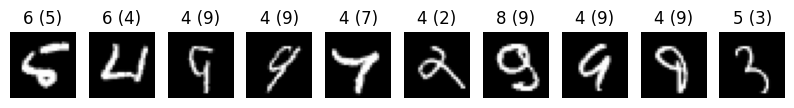

In [40]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))
show_failures(nonlinear_model, test_dataloader)

1) Changing batch size: I'll use the non linear model with 5 epoches for each batches, and I will compare their test accuracy.

In [41]:
#accuracy vs batch size function
def accuracy_vs_batch_size(batch_sizes):
    accs = []
    train_acc_alls = []
    val_acc_alls = []
    for bs in batch_sizes:
        train_dataloader, val_dataloader = loading_data(bs)
        model = NonlinearClassifier()
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
        train_acc_all, val_acc_all = train_multiple_epochs(model, train_dataloader, val_dataloader, loss_fn, optimizer, 5)
        train_acc_alls.append(train_acc_all)
        val_acc_alls.append(val_acc_all)
        acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
        accs.append(acc_test)
    return accs, train_acc_alls, val_acc_alls

batch_sizes = [32, 64, 128, 256, 512, 1024]
accs, train_acc_alls, val_acc_alls = accuracy_vs_batch_size(batch_sizes)

Epoch 0: training loss: 0.2809131566757957, accuracy: 91.88125000000001
Epoch 0: val. loss: 0.2770863500436147, val. accuracy: 91.64166666666667
Epoch 1: training loss: 0.1817072940648844, accuracy: 94.57291666666666
Epoch 1: val. loss: 0.18879350631932418, val. accuracy: 94.15
Epoch 2: training loss: 0.1363112325553472, accuracy: 95.84583333333333
Epoch 2: val. loss: 0.1466394051934282, val. accuracy: 95.51666666666667
Epoch 3: training loss: 0.11804398351721465, accuracy: 96.40625
Epoch 3: val. loss: 0.13358100153754154, val. accuracy: 95.95
Epoch 4: training loss: 0.11014022399516156, accuracy: 96.65625
Epoch 4: val. loss: 0.12926268737390637, val. accuracy: 96.00833333333333
Epoch 0: training loss: 0.3869252441128095, accuracy: 88.85625
Epoch 0: val. loss: 0.3828817644017808, val. accuracy: 88.73333333333333
Epoch 1: training loss: 0.24089725324511527, accuracy: 93.0625
Epoch 1: val. loss: 0.23950414993661515, val. accuracy: 92.95
Epoch 2: training loss: 0.1849874051262935, accurac

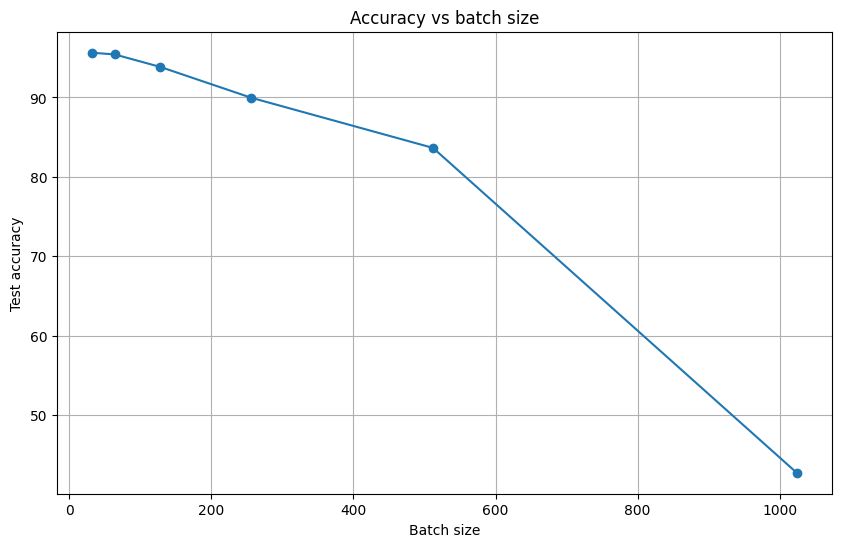

In [ ]:
#plotting accuracy vs batch size
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, accs, 'o-')
plt.xscale('log')
plt.xlabel('Batch size')
plt.ylabel('Test accuracy')
plt.title('Accuracy vs batch size')
plt.grid()
plt.show()


This plot show that for this case, the larger the batch size the lower the test accuracy. I wonder what happen if I reduce the batch size instead of increasing it. The next graph will present it.

In [47]:
batch_sizes2 = [1, 2, 4, 8, 16]
accs2, train_acc_alls2, val_acc_alls2 = accuracy_vs_batch_size(batch_sizes2)

Epoch 0: training loss: 1.5329671569757126, accuracy: 35.38333333333333
Epoch 0: val. loss: 1.5222055210384327, val. accuracy: 35.15
Epoch 1: training loss: 2.3155058336779475, accuracy: 9.925
Epoch 1: val. loss: 2.316467990398407, val. accuracy: 9.633333333333335
Epoch 2: training loss: 2.314009203761816, accuracy: 9.08125
Epoch 2: val. loss: 2.3148773321111995, val. accuracy: 8.85
Epoch 3: training loss: 2.314009203761816, accuracy: 9.08125
Epoch 3: val. loss: 2.3148773321111995, val. accuracy: 8.85
Epoch 4: training loss: 2.314009203761816, accuracy: 9.08125
Epoch 4: val. loss: 2.3148773321111995, val. accuracy: 8.85
Epoch 0: training loss: 0.24741119642858989, accuracy: 93.13333333333334
Epoch 0: val. loss: 0.25512941131315714, val. accuracy: 93.15833333333333
Epoch 1: training loss: 0.24694445102216234, accuracy: 93.61458333333333
Epoch 1: val. loss: 0.26374506152678984, val. accuracy: 93.16666666666666
Epoch 2: training loss: 0.2972939737998785, accuracy: 92.36458333333334
Epoch 

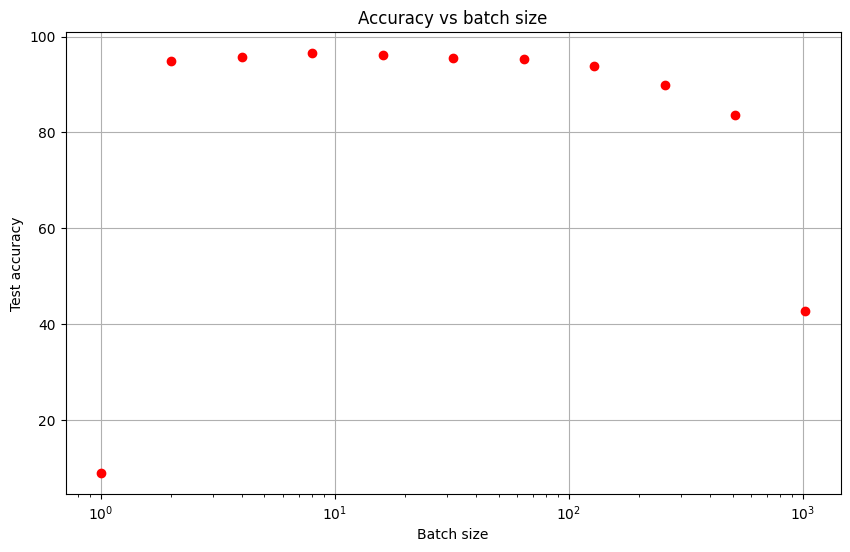

In [59]:
#plotting accuracy vs batch size
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes2, accs2, 'o',color="red")
plt.plot(batch_sizes, accs, 'o', color="red")
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Batch size')
plt.ylabel('Test accuracy')
plt.title('Accuracy vs batch size')
plt.grid()
plt.show()


This plot shows that the model performs much better at lower batches, and it peaks at around 8 batches. However, the training time increase as we lower the number of batches. The test accuracy stay relatively the same from 2 to 128 batches. This indicates that we can use 128 batches for our training to reduce time while keeping most of the model performence.

2) Chaning learning rate. In this case, I will also keep the number of epoch to be 5 and the batch size is 128, while changing the learning rate from 0.0001 to 1

In [60]:
def accuracy_vs_learning_rate(learning_rates):
    accs = []
    train_acc_alls = []
    val_acc_alls = []
    for lr in learning_rates:
        train_dataloader, val_dataloader = loading_data(128)
        model = NonlinearClassifier()
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        train_acc_all, val_acc_all = train_multiple_epochs(model, train_dataloader, val_dataloader, loss_fn, optimizer, 5)
        train_acc_alls.append(train_acc_all)
        val_acc_alls.append(val_acc_all)
        acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
        accs.append(acc_test)
    return accs, train_acc_alls, val_acc_alls

In [61]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
accs, train_acc_alls, val_acc_alls = accuracy_vs_learning_rate(learning_rates)

Epoch 0: training loss: 2.2998766714731853, accuracy: 10.96875
Epoch 0: val. loss: 2.2998024073052914, val. accuracy: 10.716666666666667
Epoch 1: training loss: 2.299705451329549, accuracy: 11.054166666666667
Epoch 1: val. loss: 2.2996284682699977, val. accuracy: 10.858333333333334
Epoch 2: training loss: 2.29953378423055, accuracy: 11.183333333333334
Epoch 2: val. loss: 2.299454148779524, val. accuracy: 11.008333333333335
Epoch 3: training loss: 2.2993623396555583, accuracy: 11.289583333333333
Epoch 3: val. loss: 2.2992800930713084, val. accuracy: 11.116666666666667
Epoch 4: training loss: 2.2991909790039062, accuracy: 11.420833333333333
Epoch 4: val. loss: 2.299106166717854, val. accuracy: 11.291666666666666
Epoch 0: training loss: 2.303416707356771, accuracy: 12.3125
Epoch 0: val. loss: 2.303420566497965, val. accuracy: 12.233333333333334
Epoch 1: training loss: 2.3011037572224935, accuracy: 12.983333333333333
Epoch 1: val. loss: 2.3010998380945082, val. accuracy: 13.091666666666665

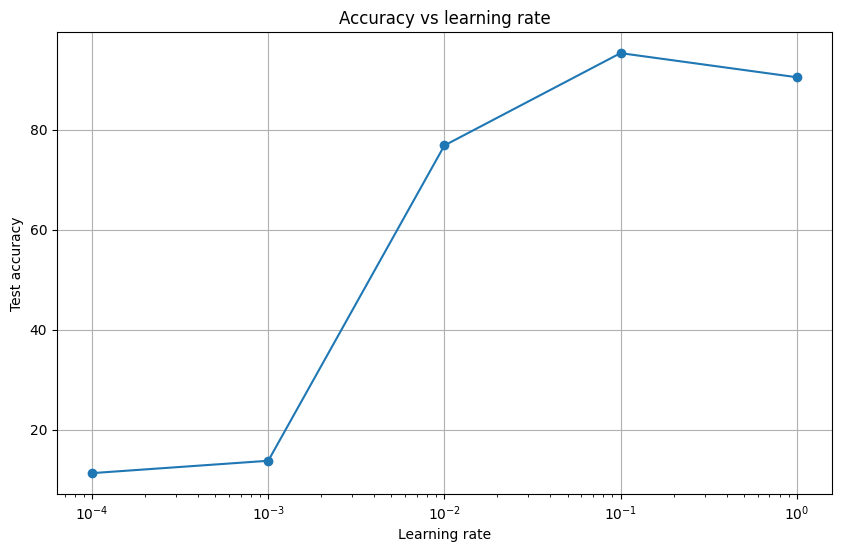

In [62]:
#plotting accuracy vs learning rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, accs, 'o-')
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Test accuracy')
plt.title('Accuracy vs learning rate')
plt.grid()
plt.show()


The accuracy of the model peaks around 0.01. 

3) Changing activation function

In [63]:
class Classifier_LeakyErLu(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x
class Classifier_ELU(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x
class Classifier_Sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
        # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
        # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x
class Classifier_GELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.GELU(),
        # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.GELU(),
        # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x
    
def accuracy_vs_activation_function(activation_functions):
    accs = []
    train_acc_alls = []
    val_acc_alls = []
    for af in activation_functions:
        train_dataloader, val_dataloader = loading_data(128)
        model = af()
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
        train_acc_all, val_acc_all = train_multiple_epochs(model, train_dataloader, val_dataloader, loss_fn, optimizer, 5)
        train_acc_alls.append(train_acc_all)
        val_acc_alls.append(val_acc_all)
        acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
        accs.append(acc_test)
    return accs, train_acc_alls, val_acc_alls

In [64]:
activation_functions = [Classifier_LeakyErLu, Classifier_ELU, Classifier_Sigmoid, Classifier_GELU, NonlinearClassifier, LinearClassifier]
accs, train_acc_alls, val_acc_alls = accuracy_vs_activation_function(activation_functions)

Epoch 0: training loss: 0.7350503393809, accuracy: 77.93958333333333
Epoch 0: val. loss: 0.7225866387499139, val. accuracy: 78.05833333333332
Epoch 1: training loss: 0.3890180747906367, accuracy: 89.10208333333334
Epoch 1: val. loss: 0.37980163604655165, val. accuracy: 88.85
Epoch 2: training loss: 0.30070836905638376, accuracy: 91.55833333333334
Epoch 2: val. loss: 0.29068625575684487, val. accuracy: 91.425
Epoch 3: training loss: 0.24431844484806062, accuracy: 93.0
Epoch 3: val. loss: 0.23890720157230155, val. accuracy: 92.85833333333333
Epoch 4: training loss: 0.20180508132775624, accuracy: 94.14791666666666
Epoch 4: val. loss: 0.20127119805584562, val. accuracy: 93.95
Epoch 0: training loss: 0.47388606683413187, accuracy: 86.80208333333333
Epoch 0: val. loss: 0.4651494111786497, val. accuracy: 86.58333333333333
Epoch 1: training loss: 0.3405958490769068, accuracy: 90.21458333333334
Epoch 1: val. loss: 0.3307084929435811, val. accuracy: 90.125
Epoch 2: training loss: 0.2982864483197

In [ ]:
Act_Func_Names = ['LeakyReLU', 'ELU', 'Sigmoid', 'GELU', 'ReLu', 'LinearClassifier']
#Sort the accuracy and names
accs, Act_Func_Names = zip(*sorted(zip(accs, Act_Func_Names)))

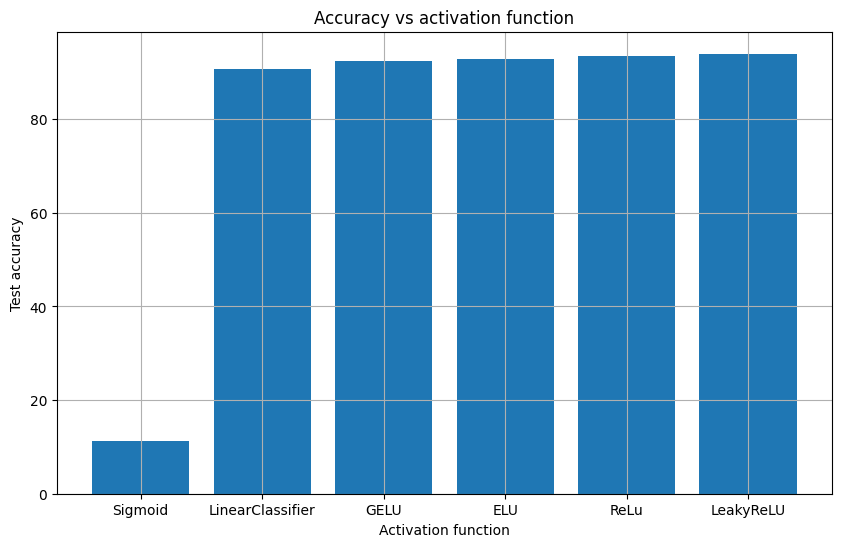

In [70]:
#plotting accuracy vs activation function
plt.figure(figsize=(10, 6))
plt.bar(Act_Func_Names, accs)
plt.xlabel('Activation function')
plt.ylabel('Test accuracy')
plt.title('Accuracy vs activation function')
plt.grid()
plt.show()


Out of all tested activation function, the Leaky ReLu performs best.

Bonus: What is a learning rate scheduler?
A learning rate scheduler is a tool in machine learning that adjusts the learning rate (the step size for each update) throughout training. Rather than keeping the learning rate fixed, a scheduler changes it over time to help the model learn more efficiently.

At the beginning of training, a higher learning rate can help the model make bigger adjustments, speeding up early learning. But as training progresses, lowering the learning rate helps fine-tune the model by making smaller, more precise updates. This adjustment often leads to faster convergence (reaching the optimal model settings) and can improve the model’s final performance, like accuracy or loss minimization.

Different strategies—like gradually lowering the rate, or adjusting it only when progress stalls—can be chosen depending on the model's needs.